# VampNet ONNX Optimization and Quantization

This notebook demonstrates how to optimize and quantize VampNet ONNX models for better performance and smaller size.

In [1]:
import numpy as np
import onnx
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, quantize_static, QuantType
from onnxruntime.quantization.calibrate import CalibrationDataReader
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt

# Add parent directory to path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./'))))

# Import our VampNet ONNX utilities
from vampnet_onnx import (
    export_all_components,
    benchmark_model,
    create_onnx_session
)
from vampnet_onnx.exporters import export_codec_encoder, export_codec_decoder

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export/venv/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## 1. Export Models (if not already done)

In [2]:
# Export all components if needed
model_dir = "../onnx_models"

# Check if we need to export the VampNet codec models
vampnet_codec_dir = "../onnx_models/vampnet_codec"
if not os.path.exists(os.path.join(vampnet_codec_dir, "encoder.onnx")):
    print("Exporting VampNet codec models...")
    
    # Load vampnet interface
    import vampnet
    interface = vampnet.interface.Interface(
        codec_ckpt="../models/vampnet/codec.pth",
        coarse_ckpt="../models/vampnet/coarse.pth"
    )
    codec_model = interface.codec
    
    # Export encoder
    export_codec_encoder(
        output_path=os.path.join(vampnet_codec_dir, "encoder.onnx"),
        use_vampnet=True,
        codec_model=codec_model,
        device='cpu'
    )
    
    # Export decoder
    export_codec_decoder(
        output_path=os.path.join(vampnet_codec_dir, "decoder.onnx"),
        use_vampnet=True,
        codec_model=codec_model,
        device='cpu'
    )
else:
    print(f"VampNet codec models already exported to {vampnet_codec_dir}")

# Also export other components if needed
if not os.path.exists(os.path.join(model_dir, "audio_processor.onnx")):
    print("\nExporting other components...")
    exported_models = export_all_components(
        output_dir=model_dir,
        # Use simplified versions for testing
        codec_encoder={'use_simplified': True},
        codec_decoder={'use_simplified': True},
        transformer={'use_simplified': True}
    )
else:
    print(f"\nOther models already exported to {model_dir}")
    
# List all exported models
all_models = []
# Add VampNet codec models
for f in Path(vampnet_codec_dir).glob("*.onnx"):
    all_models.append(f)
# Add other models
for f in Path(model_dir).glob("*.onnx"):
    if f.parent.name != "vampnet_codec":  # Skip duplicates
        all_models.append(f)

print("\n\nAll exported models:")
for model_file in all_models:
    size_mb = os.path.getsize(model_file) / (1024 * 1024)
    print(f"  - {model_file.parent.name}/{model_file.name}: {size_mb:.2f} MB")

VampNet codec models already exported to ../onnx_models/vampnet_codec

Other models already exported to ../onnx_models


All exported models:
  - vampnet_codec/decoder.onnx: 487.08 MB
  - vampnet_codec/decoder_opt.onnx: 487.10 MB
  - vampnet_codec/encoder.onnx: 87.27 MB
  - vampnet_codec/encoder_opt.onnx: 87.63 MB
  - onnx_models/transformer.onnx: 38.16 MB
  - onnx_models/mask_generator.onnx: 0.01 MB
  - onnx_models/codec_decoder_opt.onnx: 100.52 MB
  - onnx_models/audio_processor.onnx: 0.01 MB
  - onnx_models/codec_decoder.onnx: 100.52 MB
  - onnx_models/codec_encoder.onnx: 72.63 MB
  - onnx_models/codec_encoder_opt.onnx: 72.61 MB
  - onnx_models/transformer_opt.onnx: 38.04 MB


In [3]:
def apply_dynamic_quantization(input_path: str, output_path: str, weight_type=QuantType.QUInt8):
    """
    Apply dynamic quantization to reduce model size.
    """
    try:
        # Fix type inference issues before quantization
        import onnx
        import onnx.shape_inference
        
        # Load and infer shapes to fix missing type information
        model = onnx.load(input_path)
        if len(model.graph.value_info) == 0:
            print("  Fixing missing type information...")
            model = onnx.shape_inference.infer_shapes(model)
            # Save fixed model to temp file
            temp_path = input_path.replace('.onnx', '_temp.onnx')
            onnx.save(model, temp_path)
            input_path = temp_path
        
        # For transformer models, we might need to specify extra options
        extra_options = {}
        if 'transformer' in input_path.lower():
            extra_options = {'DefaultTensorType': onnx.TensorProto.FLOAT}
        
        # Try quantization
        quantize_dynamic(
            model_input=input_path,
            model_output=output_path,
            weight_type=weight_type,
            extra_options=extra_options if extra_options else None
        )
        
        # Clean up temp file if created
        if 'temp.onnx' in input_path:
            os.remove(input_path)
        
        # Compare sizes
        original_size = os.path.getsize(input_path.replace('_temp.onnx', '.onnx')) / (1024 * 1024)
        quantized_size = os.path.getsize(output_path) / (1024 * 1024)
        reduction = (1 - quantized_size / original_size) * 100
        
        print(f"  Quantized: {original_size:.2f} MB -> {quantized_size:.2f} MB ({reduction:.1f}%)")
        return quantized_size
        
    except Exception as e:
        # If it fails, it might be due to unsupported operations
        print(f"  Quantization failed: {str(e)[:200]}...")
        raise

In [4]:
def optimize_onnx_model(input_path: str, output_path: str, optimization_level: int = 99):
    """
    Optimize ONNX model using ONNX Runtime optimizations.
    
    Optimization levels:
    - 0: Disable all optimizations
    - 1: Basic optimizations
    - 2: Extended optimizations (portable)
    - 99: All optimizations (may include hardware-specific)
    """
    # Create session with optimization
    sess_options = ort.SessionOptions()
    
    # Use EXTENDED level for better portability
    if optimization_level == 99:
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
        print("Warning: Using ALL optimizations (may include hardware-specific optimizations)")
    elif optimization_level == 2:
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
    elif optimization_level == 1:
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_BASIC
    else:
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_DISABLE_ALL
    
    sess_options.optimized_model_filepath = output_path
    
    # Load and optimize
    _ = ort.InferenceSession(input_path, sess_options)
    
    print(f"Optimized model saved to {output_path}")
    
    # Compare sizes
    original_size = os.path.getsize(input_path) / (1024 * 1024)
    optimized_size = os.path.getsize(output_path) / (1024 * 1024)
    reduction = (1 - optimized_size / original_size) * 100
    
    print(f"Size reduction: {original_size:.2f} MB -> {optimized_size:.2f} MB ({reduction:.1f}%)")
    return optimized_size


# Optimize each model with EXTENDED level for portability
optimized_dir = "../onnx_models_optimized"
os.makedirs(optimized_dir, exist_ok=True)

optimization_results = {}

# Use the all_models list we created earlier
for model_file in all_models:
    print(f"\nOptimizing {model_file.name}...")
    
    output_path = os.path.join(optimized_dir, model_file.name)
    # Use level 2 (EXTENDED) for portable optimizations
    optimized_size = optimize_onnx_model(str(model_file), output_path, optimization_level=2)
    
    optimization_results[model_file.name] = {
        'original': os.path.getsize(model_file) / (1024 * 1024),
        'optimized': optimized_size
    }


Optimizing decoder.onnx...
Optimized model saved to ../onnx_models_optimized/decoder.onnx
Size reduction: 487.08 MB -> 487.10 MB (-0.0%)

Optimizing decoder_opt.onnx...
Optimized model saved to ../onnx_models_optimized/decoder_opt.onnx
Size reduction: 487.10 MB -> 487.05 MB (0.0%)

Optimizing encoder.onnx...
Optimized model saved to ../onnx_models_optimized/encoder.onnx
Size reduction: 87.27 MB -> 87.63 MB (-0.4%)

Optimizing encoder_opt.onnx...
Optimized model saved to ../onnx_models_optimized/encoder_opt.onnx
Size reduction: 87.63 MB -> 87.60 MB (0.0%)

Optimizing transformer.onnx...
Optimized model saved to ../onnx_models_optimized/transformer.onnx
Size reduction: 38.16 MB -> 38.04 MB (0.3%)

Optimizing mask_generator.onnx...
Optimized model saved to ../onnx_models_optimized/mask_generator.onnx
Size reduction: 0.01 MB -> 0.00 MB (38.2%)

Optimizing codec_decoder_opt.onnx...
Optimized model saved to ../onnx_models_optimized/codec_decoder_opt.onnx
Size reduction: 100.52 MB -> 100.52 

In [5]:
# Apply dynamic quantization to all models including VampNet codec
print("\nApplying dynamic quantization...")
print("Note: Warnings about preprocessing and data type inference are normal.\n")

# Models to quantize with their configurations
models_to_quantize = [
    # VampNet codec models
    (Path(vampnet_codec_dir) / "encoder.onnx", "vampnet_encoder_int8.onnx", QuantType.QUInt8),
    (Path(vampnet_codec_dir) / "decoder.onnx", "vampnet_decoder_int8.onnx", QuantType.QUInt8),
    # Other models
    (Path(model_dir) / "transformer.onnx", "transformer_int8.onnx", QuantType.QUInt8),
    (Path(model_dir) / "codec_encoder.onnx", "simplified_encoder_int8.onnx", QuantType.QUInt8),
    (Path(model_dir) / "codec_decoder.onnx", "simplified_decoder_int8.onnx", QuantType.QUInt8),
]

quantized_dir = "../onnx_models_quantized"
os.makedirs(quantized_dir, exist_ok=True)

quantization_results = {}

for input_path, output_name, weight_type in models_to_quantize:
    if not input_path.exists():
        print(f"Skipping {input_path.name} (not found)")
        continue
        
    print(f"\nQuantizing {input_path.name}...")
    output_path = os.path.join(quantized_dir, output_name)
    
    try:
        # First optimize the model
        optimized_path = str(input_path).replace('.onnx', '_opt.onnx')
        optimize_onnx_model(str(input_path), optimized_path, optimization_level=2)
        
        # Then quantize
        quantized_size = apply_dynamic_quantization(optimized_path, output_path, weight_type=weight_type)
        
        # Clean up temp file
        if os.path.exists(optimized_path):
            os.remove(optimized_path)
            
        quantization_results[input_path.name] = {
            'original': os.path.getsize(input_path) / (1024 * 1024),
            'quantized': quantized_size
        }
    except Exception as e:
        print(f"  Failed to quantize: {str(e)[:100]}...")

print(f"\n✓ Quantization complete!")
if quantization_results:
    print("\nQuantized models:")
    for model, sizes in quantization_results.items():
        reduction = (1 - sizes['quantized']/sizes['original']) * 100
        print(f"  - {model}: {sizes['original']:.1f}MB → {sizes['quantized']:.1f}MB ({reduction:.1f}% smaller)")


Applying dynamic quantization...
Note: Warnings about preprocessing and data type inference are normal.


Quantizing encoder.onnx...
Optimized model saved to ../onnx_models/vampnet_codec/encoder_opt.onnx
Size reduction: 87.27 MB -> 87.63 MB (-0.4%)


  elem_type: 7
  shape {
    dim {
      dim_value: 3
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 3
    }
    dim {
      dim_value: 2
    }
  }
}
.
INFO:root:Quantization parameters for tensor:"/Pad_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"input.3" not specified
INFO:root:Quantization parameters for tensor:"input.7" not specified
INFO:root:Quantization parameters for tensor:"input.11" not specified
INFO:root:Quantization parameters for tensor:"input.15" not specified
INFO:root:Quantization parameters for tensor:"input.19" not specified
INFO:root:Quantization parameters for tensor:"input.23" not specified
INFO:root:Quantization parameters for tensor:"input.27" not specified
INFO:root:Quantization parameters for tensor:"input.31" not specified
INFO:root:Quantization parameters for tensor:"input.35" not specified
INFO:root:Quantization parameters for tensor:"input.39" not specified
INFO:root:Quantizat

  Quantized: 87.63 MB -> 22.67 MB (74.1%)

Quantizing decoder.onnx...
Optimized model saved to ../onnx_models/vampnet_codec/decoder_opt.onnx
Size reduction: 487.08 MB -> 487.10 MB (-0.0%)


INFO:root:Quantization parameters for tensor:"/Add_13_output_0" not specified
INFO:root:Quantization parameters for tensor:"input.107" not specified
INFO:root:Quantization parameters for tensor:"input.111" not specified
INFO:root:Quantization parameters for tensor:"input.115" not specified
INFO:root:Quantization parameters for tensor:"input.119" not specified
INFO:root:Quantization parameters for tensor:"input.123" not specified
INFO:root:Quantization parameters for tensor:"input.127" not specified
INFO:root:Quantization parameters for tensor:"input.83" not specified
INFO:root:Quantization parameters for tensor:"input.87" not specified
INFO:root:Quantization parameters for tensor:"input.91" not specified
INFO:root:Quantization parameters for tensor:"input.95" not specified
INFO:root:Quantization parameters for tensor:"input.99" not specified
INFO:root:Quantization parameters for tensor:"input.103" not specified
INFO:root:Quantization parameters for tensor:"input.59" not specified
INFO:

  Quantized: 487.10 MB -> 171.75 MB (64.7%)

Quantizing transformer.onnx...
Optimized model saved to ../onnx_models/transformer_opt.onnx
Size reduction: 38.16 MB -> 38.04 MB (0.3%)


INFO:root:Quantization parameters for tensor:"/model/transformer/layers.0/self_attn/Transpose_output_0" not specified
INFO:root:Ignore MatMul due to non constant B: /[/model/transformer/layers.0/self_attn/MatMul_1]
INFO:root:Ignore MatMul due to non constant B: /[/model/transformer/layers.0/self_attn/MatMul_2]
INFO:root:Quantization parameters for tensor:"/model/transformer/layers.0/self_attn/Reshape_9_output_0" not specified
INFO:root:Quantization parameters for tensor:"/model/transformer/layers.0/norm1/Add_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/model/transformer/layers.0/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/model/transformer/layers.1/self_attn/Transpose_output_0" not specified
INFO:root:Ignore MatMul due to non constant B: /[/model/transformer/layers.1/self_attn/MatMul_1]
INFO:root:Ignore MatMul due to non constant B: /[/model/transformer/layers.1/self_attn/MatMul_2]
INFO:root:Quantization parameters for tensor:

  Quantized: 38.04 MB -> 17.07 MB (55.1%)

Quantizing codec_encoder.onnx...
Optimized model saved to ../onnx_models/codec_encoder_opt.onnx
Size reduction: 72.63 MB -> 72.61 MB (0.0%)


INFO:root:Quantization parameters for tensor:"/encoder/encoder.3/Relu_output_0" not specified


  Quantized: 72.61 MB -> 41.11 MB (43.4%)

Quantizing codec_decoder.onnx...
Optimized model saved to ../onnx_models/codec_decoder_opt.onnx
Size reduction: 100.52 MB -> 100.52 MB (0.0%)


  Quantized: 100.52 MB -> 79.53 MB (20.9%)

✓ Quantization complete!

Quantized models:
  - encoder.onnx: 87.3MB → 22.7MB (74.0% smaller)
  - decoder.onnx: 487.1MB → 171.8MB (64.7% smaller)
  - transformer.onnx: 38.2MB → 17.1MB (55.3% smaller)
  - codec_encoder.onnx: 72.6MB → 41.1MB (43.4% smaller)
  - codec_decoder.onnx: 100.5MB → 79.5MB (20.9% smaller)


In [6]:
# This cell has been moved to the previous cell

## 4. Static Quantization (Advanced)

In [7]:
class VampNetCalibrationDataReader(CalibrationDataReader):
    """
    Calibration data reader for static quantization.
    """
    def __init__(self, model_name: str, n_samples: int = 10):
        self.model_name = model_name
        self.n_samples = n_samples
        self.data_iter = self._generate_calibration_data()
        
    def _generate_calibration_data(self):
        """Generate calibration data based on model type."""
        for i in range(self.n_samples):
            if 'audio_processor' in self.model_name:
                # Generate random audio
                yield {'audio': np.random.randn(1, 2, 44100).astype(np.float32)}
                
            elif 'codec_encoder' in self.model_name:
                # Generate preprocessed audio
                yield {'audio': np.random.randn(1, 1, 44100).astype(np.float32)}
                
            elif 'mask_generator' in self.model_name:
                # Generate token codes
                yield {'codes': np.random.randint(0, 1024, (1, 14, 100), dtype=np.int64)}
                
            elif 'transformer' in self.model_name:
                # Generate codes and mask
                yield {
                    'codes': np.random.randint(0, 1024, (1, 4, 100), dtype=np.int64),
                    'mask': np.random.randint(0, 2, (1, 4, 100), dtype=np.int64)
                }
                
            elif 'codec_decoder' in self.model_name:
                # Generate token codes
                yield {'codes': np.random.randint(0, 1024, (1, 14, 100), dtype=np.int64)}
                
    def get_next(self):
        return next(self.data_iter, None)


def apply_static_quantization(input_path: str, output_path: str, model_name: str):
    """
    Apply static quantization using calibration data.
    """
    # Create calibration reader
    calibration_reader = VampNetCalibrationDataReader(model_name)
    
    # Apply static quantization without optimize_model parameter
    quantize_static(
        model_input=input_path,
        model_output=output_path,
        calibration_data_reader=calibration_reader,
        quant_format=QuantType.QInt8,
        weight_type=QuantType.QInt8
    )
    
    # Compare sizes
    original_size = os.path.getsize(input_path) / (1024 * 1024)
    quantized_size = os.path.getsize(output_path) / (1024 * 1024)
    reduction = (1 - quantized_size / original_size) * 100
    
    print(f"Static quantized: {original_size:.2f} MB -> {quantized_size:.2f} MB ({reduction:.1f}%)")
    return quantized_size


# Apply static quantization to transformer (most compute-intensive)
static_quantized_dir = "onnx_models_static_quantized"
os.makedirs(static_quantized_dir, exist_ok=True)

transformer_path = os.path.join(optimized_dir, "transformer.onnx")
if os.path.exists(transformer_path):
    print("\nApplying static quantization to transformer...")
    output_path = os.path.join(static_quantized_dir, "transformer_static_int8.onnx")
    
    try:
        static_size = apply_static_quantization(transformer_path, output_path, "transformer")
    except Exception as e:
        print(f"Static quantization failed: {e}")


Applying static quantization to transformer...


INFO:root:Created a copy of bias input 'model.transformer.layers.0.self_attn.out_proj.bias' called 'model.transformer.layers.0.self_attn.out_proj.bias0'
INFO:root:Created a copy of bias input 'model.transformer.layers.0.self_attn.out_proj.bias' called 'model.transformer.layers.0.self_attn.out_proj.bias1'
INFO:root:Created a copy of bias input 'model.transformer.layers.0.self_attn.out_proj.bias' called 'model.transformer.layers.0.self_attn.out_proj.bias2'
INFO:root:Created a copy of bias input 'model.transformer.layers.0.self_attn.out_proj.bias' called 'model.transformer.layers.0.self_attn.out_proj.bias3'
INFO:root:Created a copy of bias input 'model.transformer.layers.0.self_attn.out_proj.bias' called 'model.transformer.layers.0.self_attn.out_proj.bias4'
INFO:root:Created a copy of bias input 'model.transformer.layers.0.self_attn.out_proj.bias' called 'model.transformer.layers.0.self_attn.out_proj.bias5'
INFO:root:Created a copy of bias input 'model.transformer.layers.0.self_attn.out_p

Static quantized: 38.04 MB -> 17.23 MB (54.7%)


## 5. Performance Comparison

2025-06-06 19:54:06.172374 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.0/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:06.172418 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.1/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:06.172440 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.2/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:06.172461 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.3/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:06.172484 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.4/self


Benchmarking original...
Created ONNX Runtime session with providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider']
Benchmarking model (100 runs after 10 warmup)...


Context leak detected, msgtracer returned -1


Benchmark results:
  - mean_ms: 115.90
  - std_ms: 6.02
  - min_ms: 104.44
  - max_ms: 131.26
  - median_ms: 115.42
  - p95_ms: 125.39
  - p99_ms: 131.16

Benchmarking optimized...


2025-06-06 19:54:24.453629 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.0/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:24.453668 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.1/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:24.453686 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.2/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:24.453704 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.3/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:24.453720 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.4/self

Created ONNX Runtime session with providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider']
Benchmarking model (100 runs after 10 warmup)...


Context leak detected, msgtracer returned -1


Benchmark results:
  - mean_ms: 88.32
  - std_ms: 7.97
  - min_ms: 75.03
  - max_ms: 120.54
  - median_ms: 85.97
  - p95_ms: 101.26
  - p99_ms: 103.25

Benchmarking dynamic_int8...


2025-06-06 19:54:40.097914 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.0/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:40.097961 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.1/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:40.097983 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.2/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:40.098003 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.3/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:40.098022 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.4/self

Created ONNX Runtime session with providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider']
Benchmarking model (100 runs after 10 warmup)...


Context leak detected, msgtracer returned -1


Benchmark results:
  - mean_ms: 116.91
  - std_ms: 5.89
  - min_ms: 104.19
  - max_ms: 145.19
  - median_ms: 115.92
  - p95_ms: 129.57
  - p99_ms: 134.04

Benchmarking static_int8...


2025-06-06 19:54:59.197907 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.0/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:59.197954 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.1/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:59.197978 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.2/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:59.197999 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.3/self_attn/Slice_2_output_0, shape: {0}
2025-06-06 19:54:59.198020 [W:onnxruntime:, helper.cc:89 IsInputSupported] CoreML does not support shapes with dimension values of 0. Input:/model/transformer/layers.4/self

Created ONNX Runtime session with providers: ['CoreMLExecutionProvider', 'CPUExecutionProvider']
Benchmarking model (100 runs after 10 warmup)...


Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1


Benchmark results:
  - mean_ms: 106.21
  - std_ms: 4.01
  - min_ms: 97.47
  - max_ms: 116.35
  - median_ms: 105.51
  - p95_ms: 113.80
  - p99_ms: 115.97


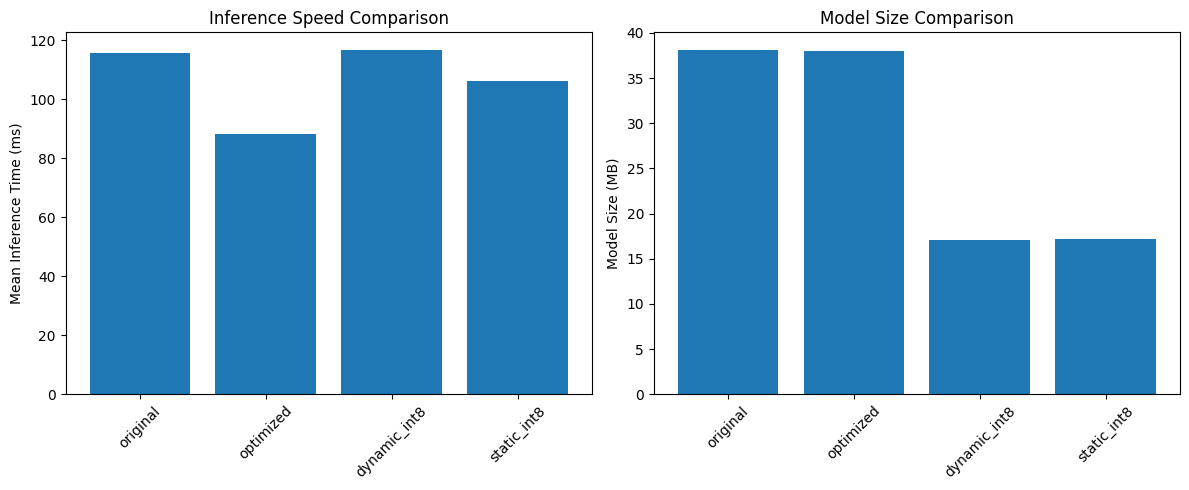

In [8]:
def compare_model_performance(model_paths: dict, input_data: dict, n_runs: int = 100):
    """
    Compare performance of different model variants.
    """
    results = {}
    
    for name, path in model_paths.items():
        if not os.path.exists(path):
            print(f"Skipping {name}: file not found")
            continue
            
        print(f"\nBenchmarking {name}...")
        
        try:
            # Create session
            session = create_onnx_session(path)
            
            # Benchmark
            stats = benchmark_model(session, input_data, n_runs=n_runs, warmup_runs=10)
            
            # Add model size
            stats['size_mb'] = os.path.getsize(path) / (1024 * 1024)
            
            results[name] = stats
            
        except Exception as e:
            print(f"Failed to benchmark {name}: {e}")
            
    return results


# Compare transformer variants
transformer_variants = {
    'original': os.path.join(model_dir, 'transformer.onnx'),
    'optimized': os.path.join(optimized_dir, 'transformer.onnx'),
    'dynamic_int8': os.path.join(quantized_dir, 'transformer_int8.onnx'),
    'static_int8': os.path.join(static_quantized_dir, 'transformer_static_int8.onnx')
}

# Test data
test_input = {
    'codes': np.random.randint(0, 1024, (1, 4, 100), dtype=np.int64),
    'mask': np.random.randint(0, 2, (1, 4, 100), dtype=np.int64)
}

# Run comparison
perf_results = compare_model_performance(transformer_variants, test_input)

# Visualize results
if perf_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Inference time
    names = list(perf_results.keys())
    mean_times = [perf_results[n]['mean_ms'] for n in names]
    
    ax1.bar(names, mean_times)
    ax1.set_ylabel('Mean Inference Time (ms)')
    ax1.set_title('Inference Speed Comparison')
    ax1.tick_params(axis='x', rotation=45)
    
    # Model size
    sizes = [perf_results[n]['size_mb'] for n in names]
    
    ax2.bar(names, sizes)
    ax2.set_ylabel('Model Size (MB)')
    ax2.set_title('Model Size Comparison')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## 6. Model Pruning (Optional)

In [9]:
def analyze_model_sparsity(model_path: str):
    """
    Analyze weight sparsity in the model.
    """
    model = onnx.load(model_path)
    
    total_params = 0
    zero_params = 0
    
    for initializer in model.graph.initializer:
        # Convert to numpy array
        if initializer.data_type == onnx.TensorProto.FLOAT:
            weights = np.frombuffer(initializer.raw_data, dtype=np.float32)
        else:
            continue
            
        total_params += weights.size
        zero_params += np.sum(np.abs(weights) < 1e-6)
        
    sparsity = zero_params / total_params * 100 if total_params > 0 else 0
    
    print(f"Model sparsity: {sparsity:.1f}%")
    print(f"Total parameters: {total_params:,}")
    print(f"Zero parameters: {zero_params:,}")
    
    return sparsity


# Analyze sparsity of models
print("\nAnalyzing model sparsity...")
for model_file in Path(optimized_dir).glob("*.onnx"):
    print(f"\n{model_file.name}:")
    analyze_model_sparsity(str(model_file))


Analyzing model sparsity...

decoder.onnx:
Model sparsity: 0.0%
Total parameters: 127,612,627
Zero parameters: 47,569

transformer.onnx:
Model sparsity: 0.0%
Total parameters: 9,911,297
Zero parameters: 2,448

mask_generator.onnx:
Model sparsity: 0.0%
Total parameters: 0
Zero parameters: 0

decoder_opt.onnx:
Model sparsity: 0.0%
Total parameters: 127,612,627
Zero parameters: 47,569

codec_decoder_opt.onnx:
Model sparsity: 0.0%
Total parameters: 26,348,033
Zero parameters: 981

audio_processor.onnx:
Model sparsity: 25.0%
Total parameters: 4
Zero parameters: 1

codec_decoder.onnx:
Model sparsity: 0.0%
Total parameters: 26,348,033
Zero parameters: 981

encoder.onnx:
Model sparsity: 0.0%
Total parameters: 22,908,146
Zero parameters: 2,868

codec_encoder.onnx:
Model sparsity: 0.0%
Total parameters: 19,015,170
Zero parameters: 477

codec_encoder_opt.onnx:
Model sparsity: 0.0%
Total parameters: 19,015,170
Zero parameters: 477

encoder_opt.onnx:
Model sparsity: 0.0%
Total parameters: 22,908,1

## 7. Optimization Summary

In [10]:
# Create optimization summary
print("\n" + "="*60)
print("OPTIMIZATION SUMMARY")
print("="*60)

for model_name in optimization_results:
    print(f"\n{model_name}:")
    
    original_size = optimization_results[model_name]['original']
    optimized_size = optimization_results[model_name]['optimized']
    
    print(f"  Original: {original_size:.2f} MB")
    print(f"  Optimized: {optimized_size:.2f} MB ({(1-optimized_size/original_size)*100:.1f}% reduction)")
    
    # Check if quantized version exists
    if model_name in quantization_results:
        quantized_size = quantization_results[model_name]['quantized']
        print(f"  Quantized: {quantized_size:.2f} MB ({(1-quantized_size/original_size)*100:.1f}% reduction)")

print("\n" + "="*60)

# Recommendations
print("\nRECOMMENDATIONS:")
print("1. Use optimized models for production deployment")
print("2. Use quantized models for edge devices or when model size is critical")
print("3. Static quantization provides best performance but requires calibration data")
print("4. Test accuracy degradation after quantization for your use case")
print("5. Consider model-specific optimizations based on deployment target")


OPTIMIZATION SUMMARY

decoder.onnx:
  Original: 487.08 MB
  Optimized: 487.10 MB (-0.0% reduction)
  Quantized: 171.75 MB (64.7% reduction)

decoder_opt.onnx:
  Original: 487.10 MB
  Optimized: 487.05 MB (0.0% reduction)

encoder.onnx:
  Original: 87.27 MB
  Optimized: 87.63 MB (-0.4% reduction)
  Quantized: 22.67 MB (74.0% reduction)

encoder_opt.onnx:
  Original: 87.63 MB
  Optimized: 87.60 MB (0.0% reduction)

transformer.onnx:
  Original: 38.16 MB
  Optimized: 38.04 MB (0.3% reduction)
  Quantized: 17.07 MB (55.3% reduction)

mask_generator.onnx:
  Original: 0.01 MB
  Optimized: 0.00 MB (38.2% reduction)

codec_decoder_opt.onnx:
  Original: 100.52 MB
  Optimized: 100.52 MB (0.0% reduction)

audio_processor.onnx:
  Original: 0.01 MB
  Optimized: 0.00 MB (36.2% reduction)

codec_decoder.onnx:
  Original: 100.52 MB
  Optimized: 100.52 MB (0.0% reduction)
  Quantized: 79.53 MB (20.9% reduction)

codec_encoder.onnx:
  Original: 72.63 MB
  Optimized: 72.61 MB (0.0% reduction)
  Quantize

## 8. Export Optimization Pipeline

In [11]:
def create_optimized_pipeline(base_model_dir: str, output_dir: str, optimization_config: dict):
    """
    Create a complete optimized pipeline with specified optimization settings.
    
    Args:
        base_model_dir: Directory with original ONNX models
        output_dir: Output directory for optimized models
        optimization_config: Dict with optimization settings per model
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for model_name, config in optimization_config.items():
        input_path = os.path.join(base_model_dir, f"{model_name}.onnx")
        if not os.path.exists(input_path):
            print(f"Skipping {model_name}: not found")
            continue
            
        print(f"\nOptimizing {model_name}...")
        
        # Step 1: Graph optimization
        if config.get('optimize_graph', True):
            temp_path = os.path.join(output_dir, f"{model_name}_opt.onnx")
            optimize_onnx_model(input_path, temp_path)
            input_path = temp_path
            
        # Step 2: Quantization
        if config.get('quantize', False):
            output_path = os.path.join(output_dir, f"{model_name}_final.onnx")
            quantize_type = config.get('quantize_type', 'dynamic')
            
            if quantize_type == 'dynamic':
                apply_dynamic_quantization(input_path, output_path)
            elif quantize_type == 'static':
                apply_static_quantization(input_path, output_path, model_name)
        else:
            output_path = os.path.join(output_dir, f"{model_name}_final.onnx")
            import shutil
            shutil.copy(input_path, output_path)
            
        # Clean up temp files
        if config.get('optimize_graph', True) and os.path.exists(temp_path):
            os.remove(temp_path)
            
    print(f"\nOptimized pipeline created in {output_dir}")


# Example configuration for production deployment
production_config = {
    'audio_processor': {
        'optimize_graph': True,
        'quantize': False  # Keep float for audio processing
    },
    'codec_encoder': {
        'optimize_graph': True,
        'quantize': True,
        'quantize_type': 'dynamic'
    },
    'mask_generator': {
        'optimize_graph': True,
        'quantize': False  # Simple operation, minimal benefit
    },
    'transformer': {
        'optimize_graph': True,
        'quantize': True,
        'quantize_type': 'dynamic'  # Use 'static' for best performance
    },
    'codec_decoder': {
        'optimize_graph': True,
        'quantize': True,
        'quantize_type': 'dynamic'
    }
}

# Create production pipeline
create_optimized_pipeline(model_dir, "onnx_models_production", production_config)


Optimizing audio_processor...
Optimized model saved to onnx_models_production/audio_processor_opt.onnx
Size reduction: 0.01 MB -> 0.00 MB (36.2%)

Optimizing codec_encoder...
Optimized model saved to onnx_models_production/codec_encoder_opt.onnx
Size reduction: 72.63 MB -> 72.61 MB (0.0%)


2025-06-06 19:55:20.584783 [W:onnxruntime:, inference_session.cc:2212 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.
2025-06-06 19:55:20.640826 [W:onnxruntime:, inference_session.cc:2212 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.
INFO:root:Quantization parameters for tensor:"/encoder/encoder.3/Relu_output_0" not specified
2025-06-06 19:55:21.347206 [W:onnxruntime:, inference_session.cc:2212 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The

  Quantized: 72.61 MB -> 41.11 MB (43.4%)

Optimizing mask_generator...
Optimized model saved to onnx_models_production/mask_generator_opt.onnx
Size reduction: 0.01 MB -> 0.00 MB (38.2%)

Optimizing transformer...
Optimized model saved to onnx_models_production/transformer_opt.onnx
Size reduction: 38.16 MB -> 38.04 MB (0.3%)


2025-06-06 19:55:21.448401 [W:onnxruntime:, inference_session.cc:2212 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.
INFO:root:Quantization parameters for tensor:"/model/transformer/layers.0/self_attn/Transpose_output_0" not specified
INFO:root:Ignore MatMul due to non constant B: /[/model/transformer/layers.0/self_attn/MatMul_1]
INFO:root:Ignore MatMul due to non constant B: /[/model/transformer/layers.0/self_attn/MatMul_2]
INFO:root:Quantization parameters for tensor:"/model/transformer/layers.0/self_attn/Reshape_9_output_0" not specified
INFO:root:Quantization parameters for tensor:"/model/transformer/layers.0/norm1/Add_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/model/transformer/layers.0/Relu_output_0" not specified
INFO:root

  Quantized: 38.04 MB -> 17.07 MB (55.1%)

Optimizing codec_decoder...
Optimized model saved to onnx_models_production/codec_decoder_opt.onnx
Size reduction: 100.52 MB -> 100.52 MB (0.0%)


  Quantized: 100.52 MB -> 79.53 MB (20.9%)

Optimized pipeline created in onnx_models_production
